# COMPARATIVE ANALYSIS OF CATARACT DETECTION WITH OPHTHALMIC IMAGE CLASSIFICATION USING DEEP NEURAL NET ALGORITHMS

## IMPORT LIBRARIES

In [5]:
# General libries
import numpy as np
import glob, cv2, os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
%matplotlib inline

# For Deep Learning
import mlxtend
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.api._v2.keras import callbacks
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# for VGG_16
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

# for RESNet50
from tensorflow.keras.applications import ResNet50


In [6]:
import warnings
warnings.filterwarnings('ignore')

## PREPARE DRIVE FOR THE DATA SET SOURCE

###  (Using Jupyter notebook)

## CATARACT DATA PRE-PROCESSING (Using the Csv Data Label Distription)
### Read in The Occular Disease Recognition csv Dataset

In [7]:
ocu_df = pd.read_csv("G:/SECOND TRIMESTER\APPLIED AI/SUMMATIVE/Ocular Data set/full_df.csv/full_df.csv")
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


###  (Using Google Colab)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# ocu_df = pd.read_csv("/content/drive/MyDrive/Philip/full_df.csv")
# ocu_df.head(5)

## Extract Cataract and Normal fundus from the Data Set


Extracting Cataract Eye Images

In [8]:
# define a function that extracts cataract and normal fundus from the ocular dataset

def has_cataract(key_word):
    if "cataract" in key_word:
        return 1
    else:
        return 0

In [9]:
ocu_df["left_eye_cataract"] = ocu_df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
ocu_df["right_eye_cataract"] = ocu_df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [10]:
# extratcing Cataract for Left eye

left_eye_cataract = ocu_df.loc[(ocu_df.C ==1) & (ocu_df.left_eye_cataract == 1)]["Left-Fundus"].values
left_eye_cataract[:20]


array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg', '629_left.jpg',
       '691_left.jpg', '726_left.jpg', '750_left.jpg', '809_left.jpg'],
      dtype=object)

In [11]:
# extratcing Cataract for right eye

right_eye_cataract = ocu_df.loc[(ocu_df.C ==1) & (ocu_df.right_eye_cataract == 1)]["Right-Fundus"].values
right_eye_cataract[:20]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg', '970_right.jpg',
       '999_right.jpg', '1062_right.jpg', '1084_right.jpg',
       '1102_right.jpg'], dtype=object)

Total Number of Left and Right cataract Eye Images extracted

In [12]:
print(f"Number of images in left eye cataract: {len(left_eye_cataract)}")
print(f"Number of images in right eye cataract: {len(right_eye_cataract)}")

Number of images in left eye cataract: 304
Number of images in right eye cataract: 290


### Combining the Cataract left eye and right eye

In [13]:
cataract_eye = np.concatenate((left_eye_cataract,right_eye_cataract),axis=0)
len(cataract_eye)

594


### Exract Normal Eye Images

In [14]:
# Extracting left eye normal randomly
left_eye_normal = ocu_df.loc[(ocu_df.C ==0) & (ocu_df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
left_eye_cataract[:20]


array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg', '629_left.jpg',
       '691_left.jpg', '726_left.jpg', '750_left.jpg', '809_left.jpg'],
      dtype=object)

In [15]:
# Extracting Right eye normal randomly
right_eye_normal = ocu_df.loc[(ocu_df.C ==0) & (ocu_df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_eye_cataract[:20]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg', '970_right.jpg',
       '999_right.jpg', '1062_right.jpg', '1084_right.jpg',
       '1102_right.jpg'], dtype=object)

Total Number of Left and Right cataract Eye Images extracted

In [16]:
print(f"Number of images in left eye noraml: {len(left_eye_normal)}")
print(f"Number of images in right eye normal: {len(right_eye_normal)}")

Number of images in left eye noraml: 250
Number of images in right eye normal: 250


### Combining the  Normal left eye and right eye

In [17]:
normal_eye = np.concatenate((left_eye_normal,right_eye_normal),axis=0)
len(normal_eye)

500

### Total Number of Cataract and Normal eye Images

In [18]:
print(f"Number of Cataract eye images : {len(cataract_eye)}")
print(f"Number of Noraml eye images: {len(normal_eye)}")

Number of Cataract eye images : 594
Number of Noraml eye images: 500


# Create New Data Set By Merging to the Pro_processed Image to the csv Labels

In [16]:
# OCU_IMG_DIR = "/content/drive/MyDrive/Philip/preprocessed_images"


### Using Jupyter Notebook

In [19]:
OCU_IMG_DIR = "D:\Pre-processed Cataract Dataset"

In [20]:
IMAGE_SIZE = 224  # Square image dimensions
DATASET_DIR = "path_to_your_dataset_directory"  # Updating the dataset directory path

labels = []
new_ocu_df = []

def create_dataset(image_category, label, dataset_dir=OCU_IMG_DIR, img_size=IMAGE_SIZE):
    """
    Create a dataset from a given image category and label.

    Args:
    - image_category (list): List of image filenames
    - label (int/str): Associated label for given image category
    - dataset_dir (str, optional): Directory where images are stored. Defaults to DATASET_DIR.
    - img_size (int, optional): Desired size for square images. Defaults to IMAGE_SIZE.

    Returns:
    - list: A shuffled dataset with image-label pairs
    """

    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)

        try:
            # Load the image in color mode
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)

            # Resize the image to the specified dimensions
            image = cv2.resize(image, (img_size, img_size))

            # Append the image and its associated label to the dataset
            new_ocu_df.append([np.array(image), np.array(label)])
        except:
            # Skip the current image if there's an error in loading or resizing
            continue

    # Shuffle the dataset
    random.shuffle(new_ocu_df)
    return new_ocu_df

In [21]:
new_ocu_df = create_dataset(cataract_eye, 1)
len(new_ocu_df)

100%|████████████████████████████████████████████████████████████████████████████████| 594/594 [00:08<00:00, 68.74it/s]


588

In [22]:
new_ocu_df = create_dataset(normal_eye, 0)
len(new_ocu_df)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 95.49it/s]


1088

## Visualization of the New Ocular Data set

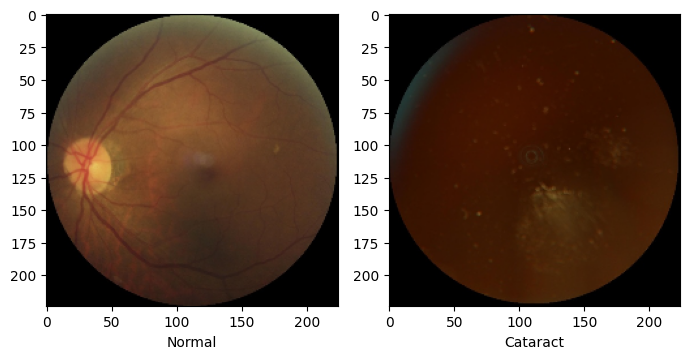

In [24]:
plt.figure(figsize=(7,5))

normal_shown = False
cataract_shown = False

tries = 0 # To ensure we don't end up in an infinite loop in case there's not enough data

while (not normal_shown or not cataract_shown) and tries < len(new_ocu_df):
    sample = random.choice(range(len(new_ocu_df)))
    image = cv2.cvtColor(new_ocu_df[sample][0], cv2.COLOR_BGR2RGB)
    category = new_ocu_df[sample][1]

    if category == 0 and not normal_shown:
        label = "Normal"
        normal_shown = True
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.xlabel(label)

    elif category == 1 and not cataract_shown:
        label = "Cataract"
        cataract_shown = True
        plt.subplot(1, 2, 2)
        plt.imshow(image)
        plt.xlabel(label)

    tries += 1

plt.tight_layout()
plt.show()

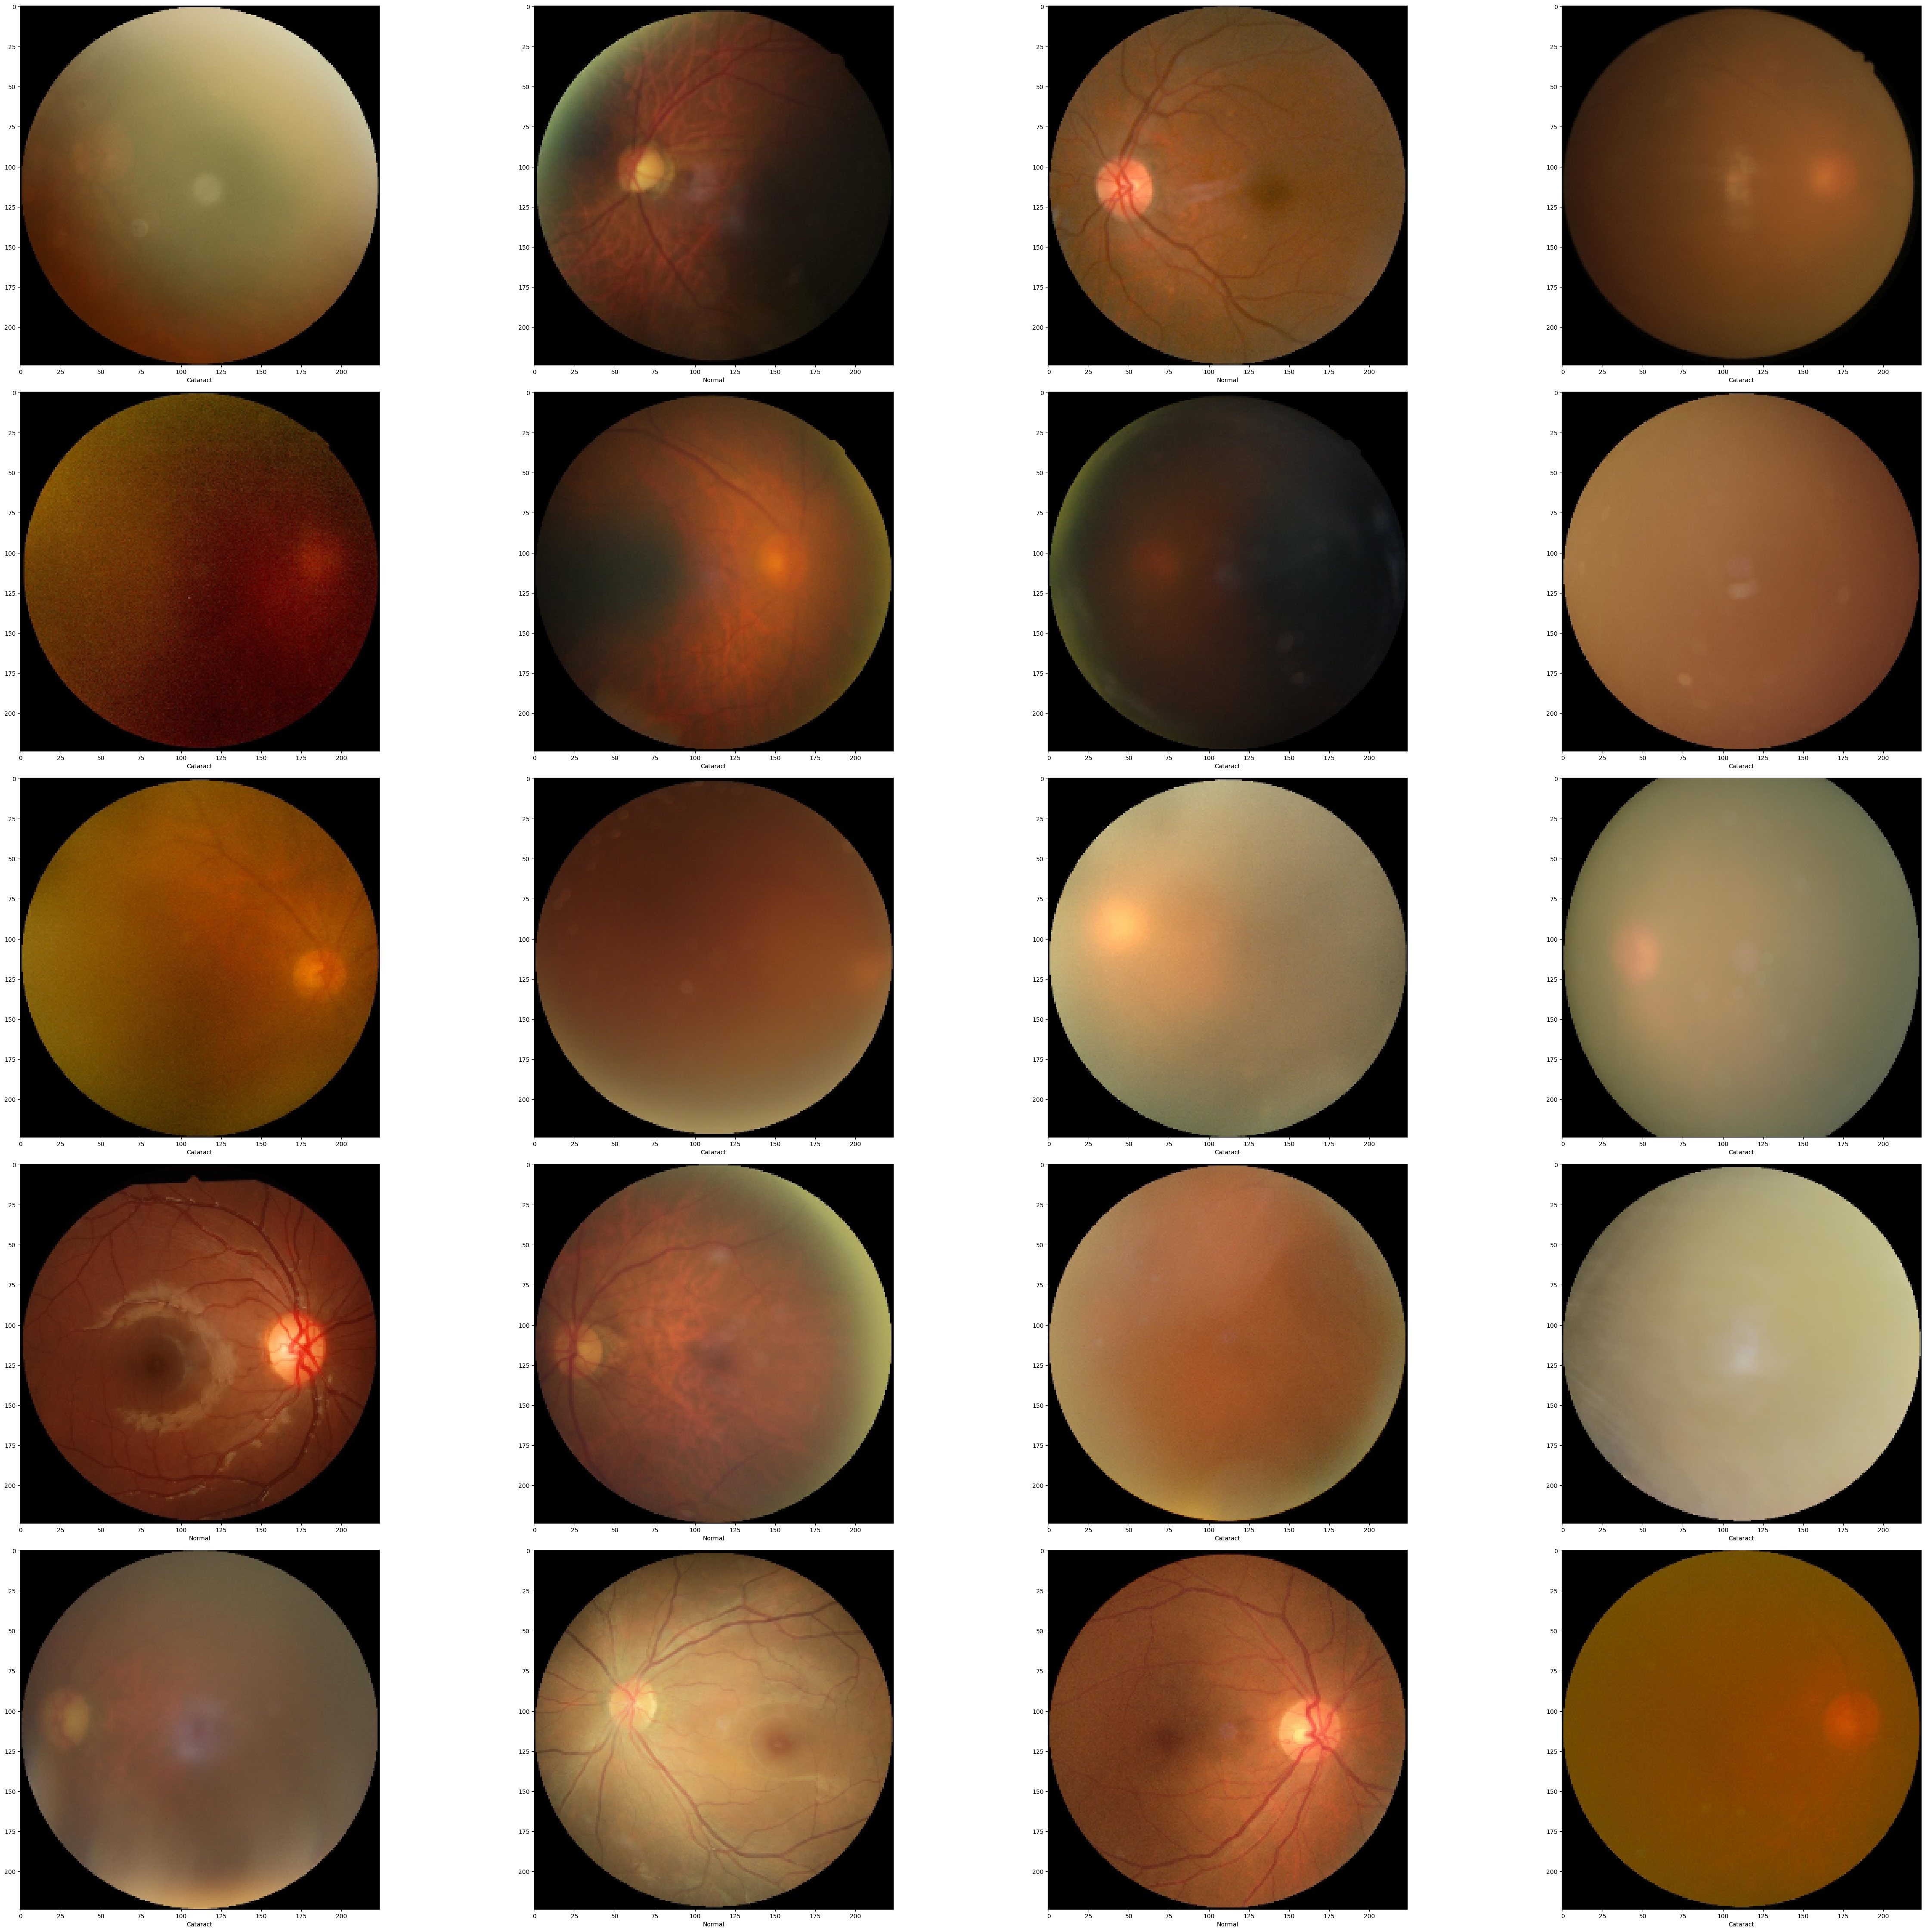

In [23]:
plt.figure(figsize=(50,45))
for i in range(20):
    sample = random.choice(range(len(new_ocu_df)))
    image = cv2.cvtColor(new_ocu_df[sample][0], cv2.COLOR_BGR2RGB)
    category = new_ocu_df[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(5,4,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

## Splitting the Data Set into Training and Testing Including Normalizing the dataset


In [47]:
# Preprocess the data
image_size = 224
X = []  # list to hold the images
y = []  # list to hold the labels

# Iterate over the images and labels
for image, label in new_ocu_df:
    # Resize the image to the desired size
    image = cv2.resize(image, (image_size, image_size))

    # Add the image and label to the lists
    X.append(image)
    y.append(label)

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [48]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Normalizing pixels values beween 0  and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# BUILDING MODEL_1 (Baseline CNN Model)

### Epoch = 10
### Input_shape = (image_size, image_size, 3)
### Activation Function = Sigmoid

In [23]:
# declaring the model
model0 = Sequential()
model0.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size, image_size, 3), activation = 'relu',padding = 'same'))
model0.add(MaxPooling2D(pool_size=(2,2)))

model0.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
model0.add(MaxPooling2D(pool_size=(2,2)))

model0.add(Conv2D(filters=128,kernel_size=(3,3),activation = 'relu'))
model0.add(MaxPooling2D(pool_size=(2,2)))

model0.add(Flatten())
model0.add(Dense(128,activation = 'relu'))

model0.add(Dense(1,activation = 'sigmoid'))


#printing the model Summary
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

## Compiling the base model and printing the accuracies and classification report

In [24]:
model0.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='binary_crossentropy', metrics = ["accuracy"])

#This means the dataset will be passed through the model 20 times for training.
history0 = model0.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

# Access training and validation accuracy
training_accuracy = history0.history['accuracy']
validation_accuracy = history0.history['val_accuracy']

# Print the accuracy values for each epoch

# Make predictions on the test data
y_pred = model0.predict(x_test)

# Convert predicted probabilities to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate and print the classification report
report = classification_report(y_test, y_pred_binary)
print("Classification Report:\n", report)

Epoch 1/10
28/28 [==============================] - 17s 103ms/step - loss: 0.6844 - accuracy: 0.5414 - val_loss: 0.6767 - val_accuracy: 0.5642
Epoch 2/10
28/28 [==============================] - 2s 61ms/step - loss: 0.6684 - accuracy: 0.5920 - val_loss: 0.6651 - val_accuracy: 0.5826
Epoch 3/10
28/28 [==============================] - 2s 55ms/step - loss: 0.6486 - accuracy: 0.6264 - val_loss: 0.6469 - val_accuracy: 0.6376
Epoch 4/10
28/28 [==============================] - 2s 77ms/step - loss: 0.6282 - accuracy: 0.6644 - val_loss: 0.6351 - val_accuracy: 0.6560
Epoch 5/10
28/28 [==============================] - 2s 75ms/step - loss: 0.6061 - accuracy: 0.6954 - val_loss: 0.6260 - val_accuracy: 0.6606
Epoch 6/10
28/28 [==============================] - 2s 68ms/step - loss: 0.6085 - accuracy: 0.6724 - val_loss: 0.6251 - val_accuracy: 0.6606
Epoch 7/10
28/28 [==============================] - 2s 58ms/step - loss: 0.5866 - accuracy: 0.6908 - val_loss: 0.6099 - val_accuracy: 0.6789
Epoch 8/10


## Plotting the result of the accuracy and loss of the base model

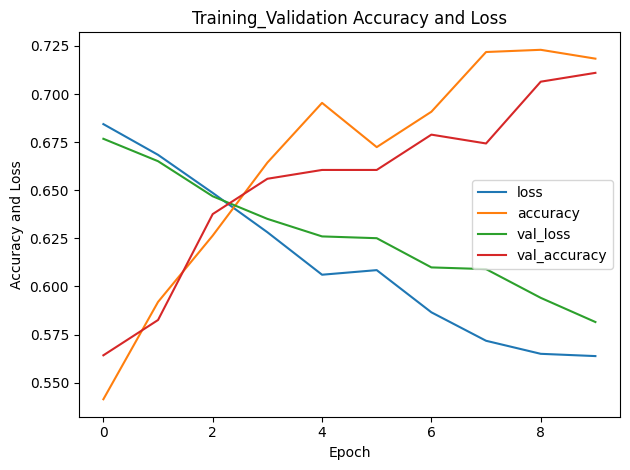

In [25]:
pd.DataFrame(history0.history).plot()
plt.title('Training_Validation Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.legend()
plt.tight_layout()

# Save the plots
plt.savefig("/content/drive/MyDrive/Philip/model0.png")

## Performing data Augumentation For model_2
### Epoch = 20
### Activation Function (output) = Signoid
### Optimizer = adam

In [26]:
# define data argumentation parameters for the training set
train_datagen = ImageDataGenerator(
  rotation_range=20, # Randomly rotate images up to 10 degrees
  width_shift_range=0.1, # Randomly shift images horizontally up to 10% of the width
  height_shift_range=0.1, # Randomly shift images vertically up to 10% of the height
  horizontal_flip=True, # Randomly flip images horizontally
  vertical_flip=False, # Don't randomly flip images vertically
  shear_range=0.10, # crops part of the image
  zoom_range=0.10 # #zooms the image by 10%
)

In [27]:
# declaring the model
model_2 = Sequential()
model_2.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size, image_size, 3), activation = 'relu',padding = 'same'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(filters=128,kernel_size=(3,3),activation = 'relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Flatten())
model_2.add(Dense(128,activation = 'relu'))

model_2.add(Dense(2,activation = 'sigmoid'))


#printing the model Summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

## Converting y_train and y_test to binary output and compiling the second model with data augmentation

In [29]:
# Label encoding the training and test dataset to binary output after they were converted to a NumPy array
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Adjust the parameters of the Adam optimizer if necessary
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model_2.compile(optimizer, loss='binary_crossentropy', metrics=["accuracy"])

# This means the dataset will be passed through the model 20 times for training.
history_2 = model_2.fit(train_datagen.flow(x_train, y_train_encoded), batch_size=32, epochs=20, validation_data=(x_test, y_test_encoded))

# Access the final training and validation accuracy
final_training_accuracy = history_2.history['accuracy'][-1]
final_validation_accuracy = history_2.history['val_accuracy'][-1]

# Print the final training and validation accuracy
print(f"Final Training Accuracy = {final_training_accuracy:.4f}")
print(f"Final Validation Accuracy = {final_validation_accuracy:.4f}")

# Evaluate the model on the test data
test_loss, test_accuracy = model_2.evaluate(x_test, y_test_encoded, verbose=0)

# Make predictions on the test data
y_pred = model_2.predict(x_test)

# Convert the predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate a classification report
classification_rep = classification_report(y_test_encoded, y_pred_binary)

# Print the classification report and final accuracy
print("Classification Report:\n", classification_rep)
print(f"Final Test Accuracy = {test_accuracy:.4f}")


Epoch 1/20
28/28 [==============================] - 13s 386ms/step - loss: 0.8239 - accuracy: 0.5425 - val_loss: 0.6636 - val_accuracy: 0.6284
Epoch 2/20
28/28 [==============================] - 11s 376ms/step - loss: 0.6528 - accuracy: 0.6092 - val_loss: 0.6724 - val_accuracy: 0.6055
Epoch 3/20
28/28 [==============================] - 9s 319ms/step - loss: 0.5986 - accuracy: 0.6862 - val_loss: 0.5831 - val_accuracy: 0.7339
Epoch 4/20
28/28 [==============================] - 10s 371ms/step - loss: 0.5810 - accuracy: 0.7161 - val_loss: 0.6665 - val_accuracy: 0.6606
Epoch 5/20
28/28 [==============================] - 10s 372ms/step - loss: 0.5797 - accuracy: 0.7207 - val_loss: 0.6018 - val_accuracy: 0.7064
Epoch 6/20
28/28 [==============================] - 12s 441ms/step - loss: 0.5782 - accuracy: 0.7011 - val_loss: 0.5866 - val_accuracy: 0.7156
Epoch 7/20
28/28 [==============================] - 14s 523ms/step - loss: 0.5710 - accuracy: 0.7368 - val_loss: 0.5904 - val_accuracy: 0.7110


## Plotting the validation and Loss values for the second model with data augmentation

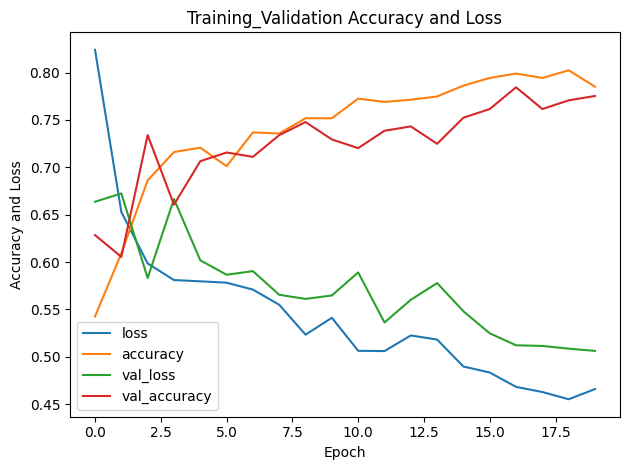

In [30]:
pd.DataFrame(history_2.history).plot()
plt.title('Training_Validation Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.legend()
plt.tight_layout()

# Save the plots
plt.savefig("/content/drive/MyDrive/Philip/model_1DataAug.png")

# Printing the accuracies and the classification report of the Second CNN model with data augmentation

In [31]:

# ... (previous code for model compilation and training)

# Evaluate the model on the test data
test_loss, test_accuracy = model_2.evaluate(x_test, y_test_encoded, verbose=0)

# Make predictions on the test data
y_pred = model_2.predict(x_test)

# Convert the predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate a classification report
classification_rep = classification_report(y_test_encoded, y_pred_binary)

# Print the classification report and final accuracy
print("Classification Report:\n", classification_rep)
print(f"Final Test Accuracy = {test_accuracy:.4f}")


7/7 [==============================] - 0s 22ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.90      0.81       101
           1       0.87      0.70      0.78       117

   micro avg       0.79      0.79      0.79       218
   macro avg       0.80      0.80      0.79       218
weighted avg       0.81      0.79      0.79       218
 samples avg       0.78      0.79      0.79       218

Final Test Accuracy = 0.7752


## Gridsearch for hyperparameter optimization of the model above

In [ ]:


# Define a function to create your CNN model with hyperparameters
def create_model(learning_rate=0.001, optimizer='adam'):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(image_size, image_size, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

    model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Load and preprocess your data here, similar to what you've done before
# Split your data into training and validation sets
x_train, x_val, y_train_encoded, y_val_encoded = train_test_split(x_train, y_train_encoded, test_size=0.2, random_state=42)

# Create a KerasClassifier wrapper for your model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters and their ranges that you want to tune using grid search
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'optimizer': ['adam', 'sgd']
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train, y_train_encoded)

# Print the best hyperparameters and their corresponding accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Use the best hyperparameters to train the final model
best_learning_rate = grid_result.best_params_['learning_rate']
best_optimizer = grid_result.best_params_['optimizer']
final_model = create_model(learning_rate=best_learning_rate, optimizer=best_optimizer)
final_model.fit(x_train, y_train_encoded, epochs=20, batch_size=32, validation_data=(x_val, y_val_encoded))

# Evaluate the final model on the test data
y_pred = final_model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)
classification_rep = classification_report(y_test_encoded, y_pred_binary)

print("Final Test Accuracy = {:.4f}".format(test_accuracy))
print("Classification Report:\n", classification_rep)


# Model_3

## Adding Batch Normalization
## Appying Data Argumentation
## Perforing Hyperparameter
## Optimization: Adam
## Dropout

In [32]:
model_3 = Sequential()

# First Convolutional Block
model_3.add(Conv2D(filters=128, kernel_size=(3,3),
                   input_shape=(image_size, image_size, 3),
                   activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2,2)))

# Second Convolutional Block
model_3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model_3.add(BatchNormalization())
#model_3.add(MaxPooling2D(pool_size=(2,2)))

# Third Convolutional Block
model_3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2,2)))
# model_3.add(Dropout(0.25))

# Fully connected layers
model_3.add(Flatten())
# model_3.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model_3.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
# model_3.add(Dropout(0.7))
# Output Layer
model_3.add(Dense(2, activation='sigmoid'))

# Printing the model summary
model_3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 128)    0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      73792     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                      

In [33]:
# Adjust the parameters of the Adam optimizer if necessary
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Applying early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model_3.compile(optimizer, loss='binary_crossentropy', metrics = ["accuracy"])

history_3 = model_3.fit(train_datagen.flow(x_train, y_train_encoded), batch_size=32, epochs=50, validation_data=(x_test, y_test_encoded),  callbacks=[early_stop])

Epoch 1/50
28/28 [==============================] - 19s 498ms/step - loss: 6.8372 - accuracy: 0.5345 - val_loss: 11.2658 - val_accuracy: 0.4908
Epoch 2/50
28/28 [==============================] - 11s 409ms/step - loss: 4.3188 - accuracy: 0.5218 - val_loss: 24.2258 - val_accuracy: 0.4725
Epoch 3/50
28/28 [==============================] - 22s 746ms/step - loss: 2.8618 - accuracy: 0.5322 - val_loss: 29.6508 - val_accuracy: 0.4633
Epoch 4/50
28/28 [==============================] - 12s 439ms/step - loss: 1.9630 - accuracy: 0.5402 - val_loss: 27.3634 - val_accuracy: 0.4633
Epoch 5/50
28/28 [==============================] - 15s 527ms/step - loss: 1.5457 - accuracy: 0.5598 - val_loss: 18.6595 - val_accuracy: 0.4633
Epoch 6/50
28/28 [==============================] - 12s 422ms/step - loss: 1.3209 - accuracy: 0.5379 - val_loss: 11.0433 - val_accuracy: 0.4633
Epoch 7/50
28/28 [==============================] - 12s 411ms/step - loss: 1.0989 - accuracy: 0.5437 - val_loss: 12.6886 - val_accuracy:

## Printing the classification report for the third model with hyperparameter tuning

In [ ]:
# ... (previous code for model compilation and training)

# Evaluate the model on the test data
test_loss, test_accuracy = model_3.evaluate(x_test, y_test_encoded, verbose=0)

# Make predictions on the test data
y_pred = model_3.predict(x_test)

# Convert the predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate a classification report
classification_rep = classification_report(y_test_encoded, y_pred_binary)

# Print the classification report and final accuracy
print("Classification Report:\n", classification_rep)
print(f"Final Test Accuracy = {test_accuracy:.4f}")

#Plotting the accurcies and loss values of the third CNN model

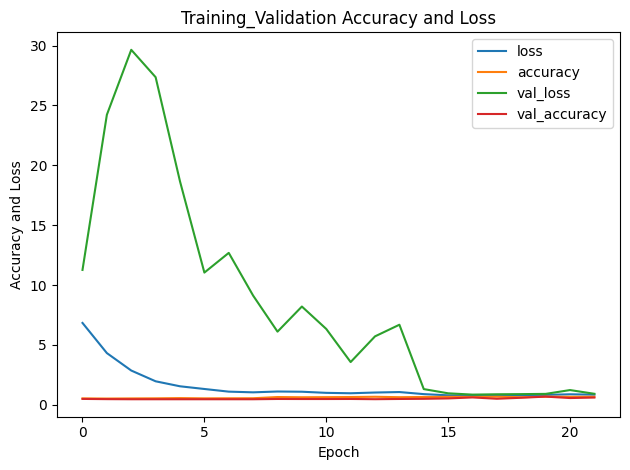

In [34]:
pd.DataFrame(history_3.history).plot()
plt.title('Training_Validation Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.legend()
plt.tight_layout()

# Save the plots
plt.savefig("/content/drive/MyDrive/Philip/model_1hyperparameter.png")

In [ ]:
# pd.DataFrame(history_3.history).plot()

## Using Pre-Trained Weight to Build Model_4
## Without Data Argumentation
### VGG-16
### Epoch = 20
## Downloading the weights for the VGG16 Model

In [49]:
# Loading the VGG model without the top classifier layers
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))


for layer in vgg.layers:
    layer.trainable = False

## Defining the VGG16 Model

In [50]:
model_vgg = Sequential()
model_vgg.add(vgg)
model_vgg.add(Flatten())
model_vgg.add(Dense(1,activation="sigmoid"))
model_vgg.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


## Compiling the VGG16 Model

In [51]:
model_vgg.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])



checkpoint = ModelCheckpoint("vgg16.h5",monitor="val_loss",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_loss",patience=3,verbose=1)

history_vgg = model_vgg.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/20
27/28 [===========================>..] - ETA: 0s - loss: 0.3978 - accuracy: 0.8310
Epoch 1: val_loss improved from inf to 0.23119, saving model to vgg16.h5
28/28 [==============================] - 7s 190ms/step - loss: 0.3959 - accuracy: 0.8322 - val_loss: 0.2312 - val_accuracy: 0.9266
Epoch 2/20
27/28 [===========================>..] - ETA: 0s - loss: 0.2071 - accuracy: 0.9259
Epoch 2: val_loss did not improve from 0.23119
28/28 [==============================] - 5s 168ms/step - loss: 0.2062 - accuracy: 0.9264 - val_loss: 0.2347 - val_accuracy: 0.9037
Epoch 3/20
27/28 [===========================>..] - ETA: 0s - loss: 0.2011 - accuracy: 0.9294
Epoch 3: val_loss improved from 0.23119 to 0.19380, saving model to vgg16.h5
28/28 [==============================] - 5s 175ms/step - loss: 0.2030 - accuracy: 0.9287 - val_loss: 0.1938 - val_accuracy: 0.9404
Epoch 4/20
27/28 [===========================>..] - ETA: 0s - loss: 0.1781 - accuracy: 0.9352
Epoch 4: val_loss improved from 0.

## Plotting the Accuracies and loss of the VGG16 model

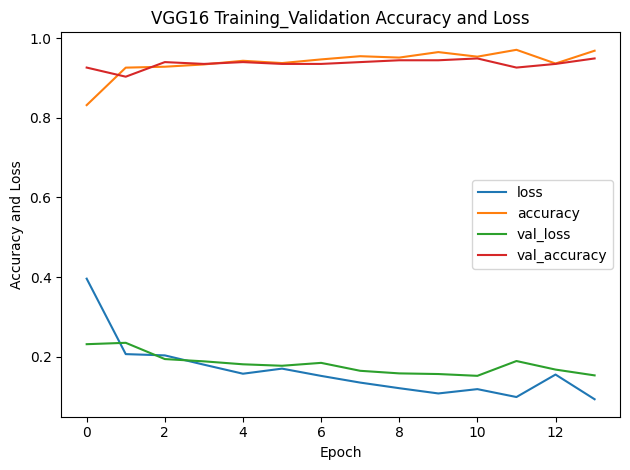

In [52]:
pd.DataFrame(history_vgg.history).plot()
plt.title("VGG16 Training_Validation Accuracy and Loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.legend()
plt.tight_layout()

# Save the plots
plt.savefig("/content/drive/MyDrive/Philip/vggmodel.png")


## Printing the classification report and confusion matrix of the VGG16 model

7/7 [==============================] - 1s 124ms/step



              precision    recall  f1-score   support

           0       0.95      0.94      0.95       101
           1       0.95      0.96      0.95       117

    accuracy                           0.95       218
   macro avg       0.95      0.95      0.95       218
weighted avg       0.95      0.95      0.95       218






<Figure size 2000x3000 with 0 Axes>

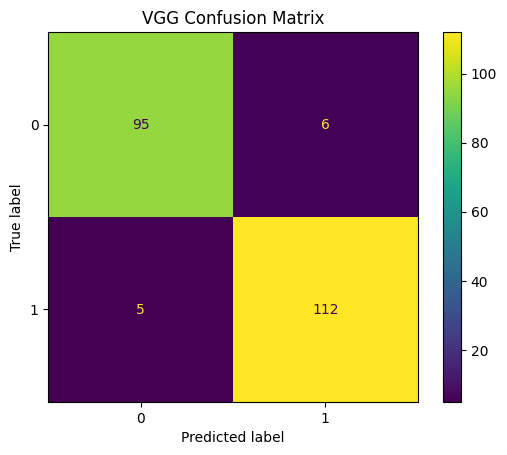




7/7 [==============================] - 1s 120ms/step - loss: 0.1528 - accuracy: 0.9495
Training accuracy: 0.9689655303955078
Validation accuracy: 0.9495412707328796
Testing accuracy: 0.9495412707328796


In [53]:
#y_pred = np.argmax(model_vgg.predict(x_test), axis=-1)
y_pred = model_vgg.predict(x = x_test,verbose = 1)
y_pred = [1 if i > 0.5 else 0 for i in y_pred]
print("\n\n" )
# Print the classification report
print(classification_report(y_test, y_pred))

print("\n\n" )
# Print the confusion matrix

plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.title('VGG Confusion Matrix')
plt.savefig("/content/drive/MyDrive/Philip/VGG_confusion_matrix.png")
plt.show()


print("\n\n" )
test_loss, test_acc = model_vgg.evaluate(x_test, y_test)
print("Training accuracy:", history_vgg.history['accuracy'][-1])
print("Validation accuracy:", history_vgg.history['val_accuracy'][-1])
print("Testing accuracy:", test_acc)

## ResNet50

## Downloading the ResNET50 Weights

In [41]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in resnet50.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


# Defining the parameters of the ResNET50 Model

In [42]:
# Add custom layers
model_rn50 = Sequential()
model_rn50.add(resnet50)
model_rn50.add(Flatten())
model_rn50.add(Dense(128, activation="relu"))
model_rn50.add(Dense(1,activation="sigmoid"))

model_rn50.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 128)               12845184  
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,433,025
Trainable params: 12,845,313
Non-trainable params: 23,587,712
_________________________________________________________________


## Compiling the ResNET50 Model

In [43]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
# Compiling the model
model_rn50.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

# add early stopping
early_stopping = EarlyStopping(monitor="val_loss",patience=3, verbose=1)
history_resnet50 = model_rn50.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 7.5437 - accuracy: 0.8575
Epoch 1: val_loss did not improve from 0.15981
28/28 [==============================] - 11s 238ms/step - loss: 7.5437 - accuracy: 0.8575 - val_loss: 2.4012 - val_accuracy: 0.9358
Epoch 2/20
27/28 [===========================>..] - ETA: 0s - loss: 1.3317 - accuracy: 0.9468
Epoch 2: val_loss did not improve from 0.15981
28/28 [==============================] - 3s 114ms/step - loss: 1.3225 - accuracy: 0.9471 - val_loss: 1.3554 - val_accuracy: 0.9266
Epoch 3/20
27/28 [===========================>..] - ETA: 0s - loss: 0.1978 - accuracy: 0.9803
Epoch 3: val_loss did not improve from 0.15981
28/28 [==============================] - 3s 119ms/step - loss: 0.1965 - accuracy: 0.9805 - val_loss: 0.8902 - val_accuracy: 0.9495
Epoch 4/20
27/28 [===========================>..] - ETA: 0s - loss: 0.0443 - accuracy: 0.9931
Epoch 4: val_loss did not improve from 0.15981
28/28 [==============================] - 4

## Plotting the ResNET50 models Accuracies and loss values

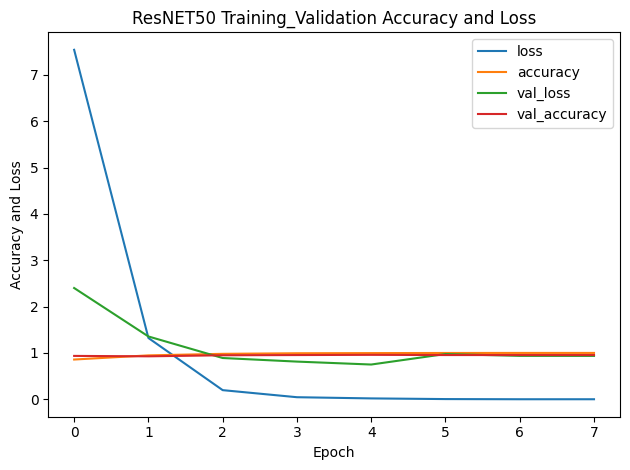

In [54]:
pd.DataFrame(history_resnet50.history).plot()
plt.title("ResNET50 Training_Validation Accuracy and Loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.legend()
plt.tight_layout()

# Save the plots
plt.savefig("/content/drive/MyDrive/Philip/ResNET50.png")


## Printing the accuracies and classfication report of the ResNET50 model including plotting the confusion matrix

7/7 [==============================] - 1s 93ms/step



              precision    recall  f1-score   support

           0       0.97      0.93      0.95       101
           1       0.94      0.97      0.96       117

    accuracy                           0.95       218
   macro avg       0.96      0.95      0.95       218
weighted avg       0.95      0.95      0.95       218






<Figure size 2000x3000 with 0 Axes>

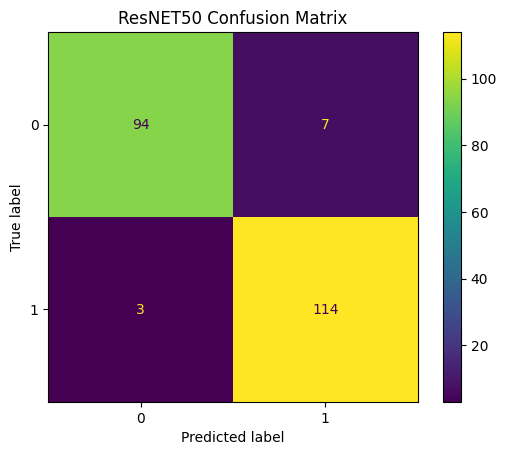




7/7 [==============================] - 1s 88ms/step - loss: 0.9358 - accuracy: 0.9541
Training accuracy: 1.0
Validation accuracy: 0.9541284441947937
Testing accuracy: 0.9541284441947937


In [44]:
# y_pred = np.argmax(resnet50.predict(x_test), axis=-1)
y_pred = model_rn50.predict(x = x_test,verbose = 1)
y_pred = [1 if i > 0.5 else 0 for i in y_pred]

print("\n\n" )
# Print the classification report
print(classification_report(y_test, y_pred))

print("\n\n" )
# Print the confusion matrix

plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.title('ResNET50 Confusion Matrix')
plt.savefig("/content/drive/MyDrive/Philip/resnet_confusion_matrix.png")
plt.show()


print("\n\n" )
test_loss, test_acc = model_rn50.evaluate(x_test, y_test)
print("Training accuracy:", history_resnet50.history['accuracy'][-1])
print("Validation accuracy:", history_resnet50.history['val_accuracy'][-1])
print("Testing accuracy:", test_acc)

## Plotting the ResNET50 Model confusion matrix to show percentage of the True Positive and True Negative values

(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

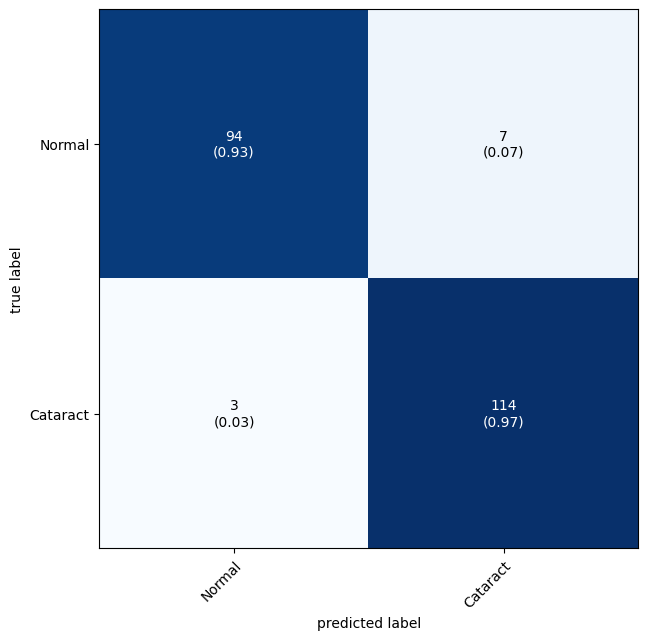

In [45]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True)